In [9]:
import numpy as np
import scipy.stats as stats
from scipy.signal import peak_widths, find_peaks
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import itertools


In [348]:
class DynaToy:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.layers = [np.zeros([m, 1]) for m in self.layer_sizes]

        self.r = np.concatenate(self.layers)
        self.W = np.zeros([len(self.r), len(self.r)])

        self.in_idx = np.arange(0, layer_sizes[0])
        self.out_idx = np.arange(len(self.r) - layer_sizes[-1], len(self.r))
        self.vth = np.zeros_like(self.r)

        self.W_ff_0 = 0.03
        self.W_ff_1 = 0.03
        self.W_fb_0 = 0.03
        self.W_fb_1 = 0.03

        self.dt = 1
        self.tau = 10   

    
    def init_weights(self, kappas = [], plot = False, return_matrices = False, recurrence = False):
        W = np.zeros_like(self.W)
        W_L = []

        
        if not kappas:
            self.kappas = [1 for i in range(len(self.layer_sizes))]
        else:
            self.kappas = kappas

        # FF and FB connection weights
        for i in range(len(self.layer_sizes) - 1):
            rstart = int(np.sum(self.layer_sizes[:(i+1)]))
            rstop = rstart + self.layer_sizes[i+1]

            cstart = int(np.sum(self.layer_sizes[:i]))
            cstop = cstart + self.layer_sizes[i]

            shape = (self.layer_sizes[i+1], self.layer_sizes[i])

            W_l = np.zeros(shape)
            x = np.linspace(0, 2*np.pi, shape[1])

            for ii in range(shape[0]):
                loc = ((ii/shape[0]) * 2*np.pi)
                rf = stats.vonmises.pdf(x, self.kappas[i], loc)
                # rf /= np.linalg.norm(rf)
                W_l[ii, :] = rf

            
            W_L.append(W_l)
            
            # FF Weights
            W[rstart:rstop, cstart:cstop] = W_l  * self.W_ff_0 - self.W_ff_1
            # FB weights
            W[cstart:cstop, rstart:rstop] = W_l.T  * self.W_fb_0 - self.W_fb_1

        if recurrence == 'vonmises':
            start = 0
            k1, k2, s1, s2 = 10, 1, 1, 1
            for i in range(len(self.layer_sizes)):
                stop = int(np.sum(self.layer_sizes[:(i+1)]))
                
                shape = [self.layer_sizes[i], self.layer_sizes[i]]
                W_l = np.zeros(shape)
                x = np.linspace(0, 2*np.pi, shape[1])

                for ii in range(shape[0]):
                    loc = ((ii/shape[0]) * 2*np.pi)
                    rf = stats.vonmises.pdf(x, k1, loc, scale = s1) - stats.vonmises.pdf(x, k2, loc, scale = s2) 
                    rf /= np.linalg.norm(rf)
                    W_l[ii, :] = rf * 1

                W[start:stop, start:stop] = W_l
                W_L.append(W_l)

                start = int(np.sum(self.layer_sizes[:(i+1)]))

        if recurrence == 'cosine':
            start = 0
            for i in range(len(self.layer_sizes)):
                stop = int(np.sum(self.layer_sizes[:(i+1)]))

                W_l = self.cos_weights(layer = i)

                W[start:stop, start:stop] = W_l
                W_L.append(W_l)

                start = int(np.sum(self.layer_sizes[:(i+1)]))


        if plot:
            plt.imshow(W)
            plt.title("Model Weights")

        if return_matrices:
            return W, W_L


        W /= np.linalg.norm(W)
        return W
    

    def step(self, r):    
        self.r = self.W @ r
        self.r /= np.linalg.norm(self.r)
        # self.r /= self.r.max()
        
        return self.r
    

    def euler(self, h):
        r = np.zeros_like(h)
        y = self.W @ self.r + h - self.vth
        y[y < 0] = 0

        r[:] = (1 - (self.dt/self.tau)) * self.r + (self.dt/self.tau) * y
        
        return r
    

    def W_theta(self, theta, W_0, W_1):
        return W_0 + 2*W_1 * np.cos(theta)


    def cos_weights(self, layer, W_0 = 0.3, W_1 = 1.5):
        delta = 2*np.pi/self.layer_sizes[0]
        grid_positions = np.arange(0, self.layer_sizes[layer])

        theta = np.linspace(0, 2*np.pi, self.layer_sizes[layer])

        W = np.zeros([theta.size, theta.size])

        # Set weights
        for i, j, in itertools.product(grid_positions, grid_positions):
            W[i, j] = self.W_theta(theta[i] - theta[j],  W_0, W_1) * (delta / (2*np.pi))

        return W
        
        




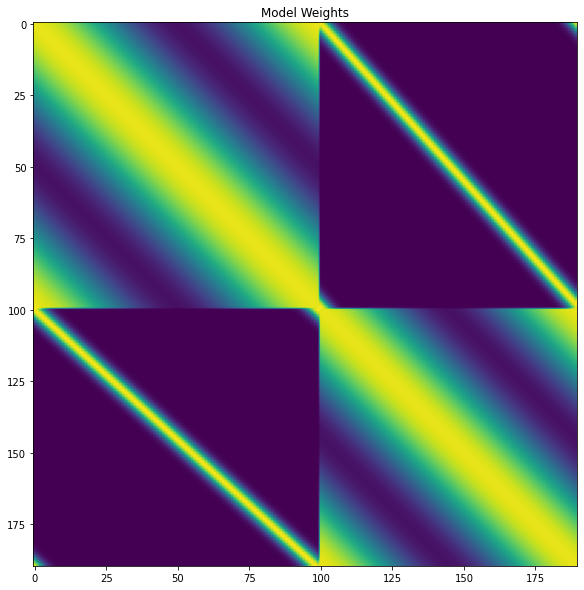

In [349]:
layer_sizes = [1000, 900, 600, 300, 200]
layer_sizes = [100, 90, 60, 30, 10]
layer_sizes = [100, 90]
kappas = [30, 20, 10, 5]

n_timesteps = 50
# kappas = []
x_pos, x_width = 180, 10
stim_on = 1


model = DynaToy(layer_sizes)

model.W, W_L = model.init_weights(plot = True, kappas = kappas, return_matrices=True, recurrence = 'cosine')

x_input = np.zeros([layer_sizes[0], 1])

center = int((x_pos/360) * layer_sizes[0])
halfwidth = int((x_width/360) * layer_sizes[0] / 2)

x_input[(center-halfwidth):(center+halfwidth)] = .1

timecourse = []
timecourse.append(model.r)

for i in range(n_timesteps):
    if i < stim_on: model.r[model.in_idx] += x_input
    timecourse.append(model.step(model.r))

plt.gcf().set_size_inches([10, 10])

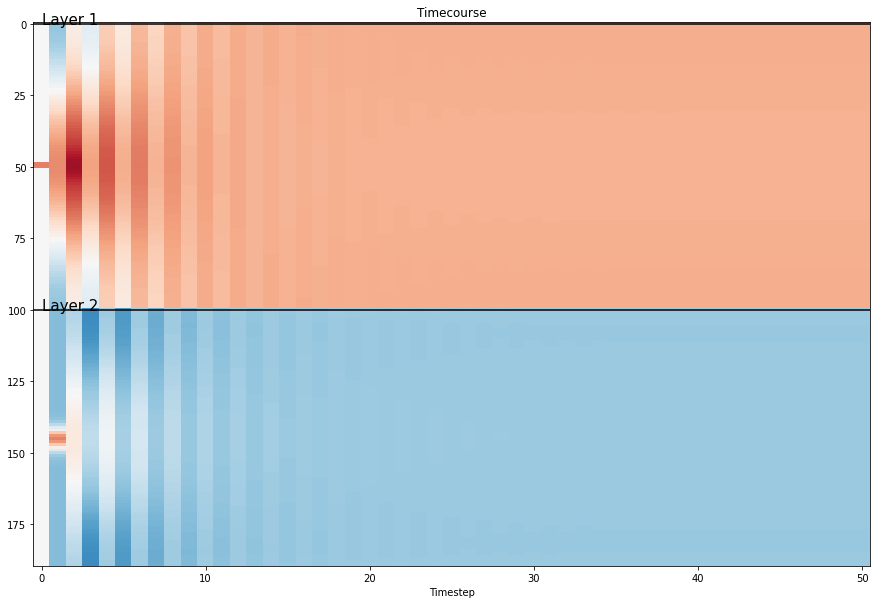

In [350]:
plt.imshow(np.asarray(timecourse).squeeze().T, origin = 'upper', aspect = 'auto', interpolation='none', cmap = 'RdBu_r', vmin = -.2, vmax = .2)
plt.gcf().set_size_inches([15, 10])
plt.xlabel("Timestep")
plt.title("Timecourse")
for i in range(len(model.layer_sizes)):
    plt.hlines(y = np.sum(model.layer_sizes[:i]), xmin = -0.5, xmax = n_timesteps + .5, color = 'black')
    plt.text(x = 0, y = np.sum(model.layer_sizes[:i]), s = "Layer " + str(i+1), color = 'black', size = 15)

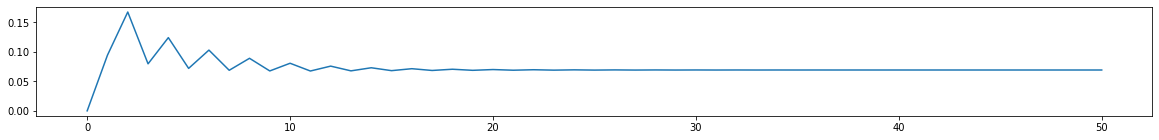

In [351]:
T = np.asarray(timecourse).squeeze()
T.shape

plt.plot(T[:, 48])
plt.gcf().set_size_inches([20, 2])

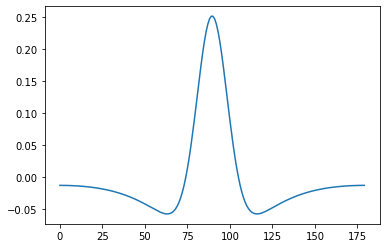

In [352]:
shape = [180, 180]
k1, k2, s1, s2 = 10, 1, 1, 1

x = np.linspace(0, 2*np.pi, shape[1])
loc = ((90/shape[0]) * 2*np.pi)
rf = stats.vonmises.pdf(x, k1, loc, scale = s1) - stats.vonmises.pdf(x, k2, loc, scale = s2) 
rf /= np.linalg.norm(rf)
plt.plot(rf)


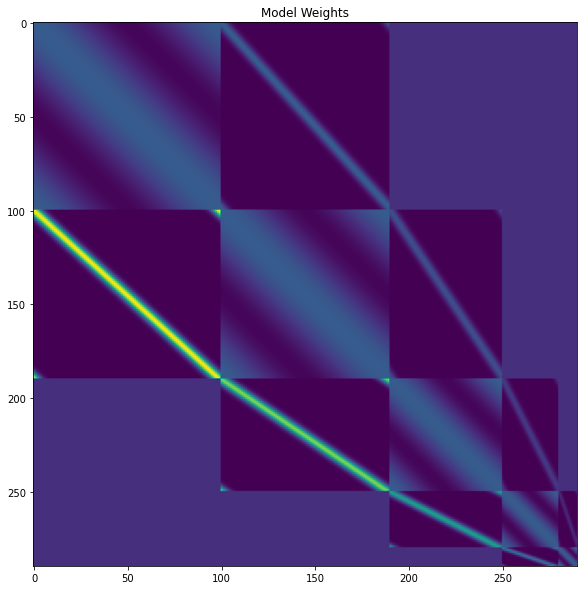

In [412]:
layer_sizes = [1000, 900, 600, 300, 200]
layer_sizes = [100, 90, 60, 30, 10]
# layer_sizes = [100]
kappas = [30, 20, 10, 5]

n_timesteps = 500
# kappas = []
x_pos, x_width = 180, 30
stim_on = 1
theta = np.linspace(0, 2*np.pi, layer_sizes[0])
theta_h = np.radians(x_pos)
stim_on = 1

model = DynaToy(layer_sizes)
model.W_ff_0 = 0.1
model.W_ff_1 = 0.03
model.W_fb_0 = 0.03
model.W_fb_1 = 0.03

model.W, W_L = model.init_weights(plot = True, kappas = kappas, return_matrices=True, recurrence = 'cosine')


x_input = np.zeros([layer_sizes[0], 1])

center = int((x_pos/360) * layer_sizes[0])
halfwidth = int((x_width/360) * layer_sizes[0] / 2)

x_input[(center-halfwidth):(center+halfwidth)] = .1

timecourse = []
timecourse.append(model.r)

h_0 = 10
h_1 = .1 * (h_0 - np.zeros(model.layer_sizes[0]))
# Set  weakly tuned input
h = h_0 + 2*h_1*np.cos((theta - theta_h)/3) 
h = np.expand_dims(h, 1)


h = np.zeros(model.layer_sizes[0])
h[(center-halfwidth):(center+halfwidth)] = 12
H = []

for i in range(n_timesteps):
    x_in = np.zeros_like(model.r)

    if i < stim_on:
        x_in[:model.layer_sizes[0]] = np.expand_dims(h, 1)
        model.r = model.euler(h = x_in)

    else:
        model.r = model.euler(h = x_in)

    H.append(x_in)

        
    timecourse.append(model.r)

plt.gcf().set_size_inches([10, 10])

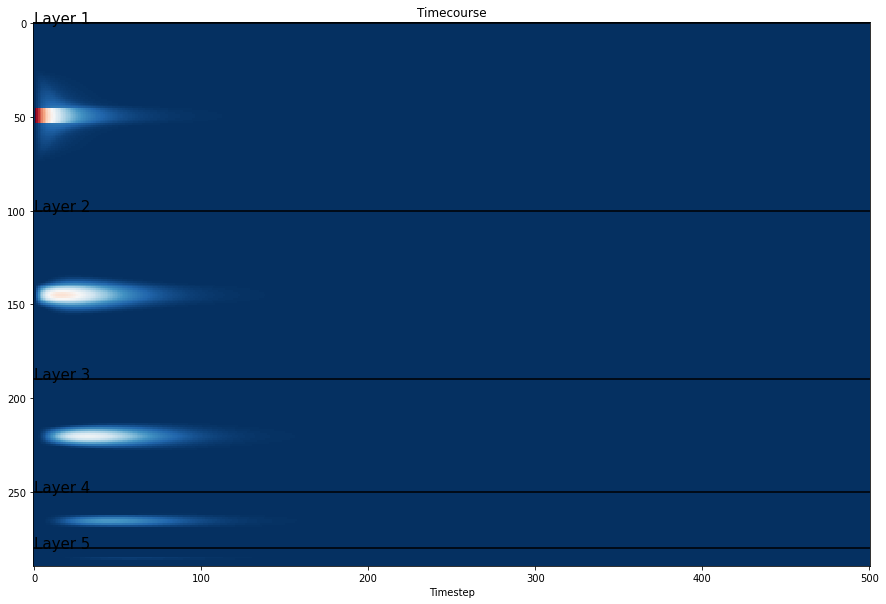

In [414]:
T = np.asarray(timecourse).squeeze().T

plt.imshow(np.asarray(timecourse).squeeze().T, origin = 'upper', aspect = 'auto', interpolation='none', cmap = 'RdBu_r')
plt.gcf().set_size_inches([15, 10])
plt.xlabel("Timestep")
plt.title("Timecourse")
for i in range(len(model.layer_sizes)):
    plt.hlines(y = np.sum(model.layer_sizes[:i]), xmin = -0.5, xmax = n_timesteps + .5, color = 'black')
    plt.text(x = 0, y = np.sum(model.layer_sizes[:i]), s = "Layer " + str(i+1), color = 'black', size = 15)

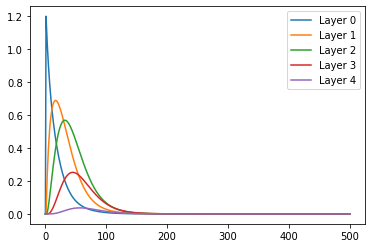

In [419]:

start = 0
for i in range(len(model.layer_sizes)):
    midpoint = int(start + model.layer_sizes[i]/2)
    timeseries = T[midpoint, :]
    start += model.layer_sizes[i]
    plt.plot(timeseries, label = 'Layer %d' % i)

plt.legend()